# Academic Labels
This notebook contains analysis of CORAL results on notebooks from academic papers. 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy.stats
import json
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches



import missingno as msno
import os
import glob
import ast
from copy import deepcopy
import statsmodels.api as sm
from statsmodels.compat import lzip
import itertools
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,10
plt.rcParams['agg.path.chunksize'] = 20000

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
LABELS_RAW = "/projects/bdata/jupyter/results/train/results_graphs_layer_4_1_12.model.ep2_0116_2020.txt"
ACADEMIC_LABELS_RAW = "/projects/bdata/jupyter/results/academic/results_graphs_layer_4_1_12.model.ep2_0122_2020.txt"

In [3]:
READABLE_LABELS = ["STAGE_PAD","WRANGLE","EXPLORE","MODEL","EVALUATE","IMPORT"]
ORDERED_LABELS = ["IMPORT","WRANGLE","EXPLORE","MODEL","EVALUATE","STAGE_PAD"]
READABLE_LABEL_TO_INT = dict(zip(READABLE_LABELS,range(len(READABLE_LABELS))))

def path_to_nb_id(path):
    filename = path.split("/")[-1]
    no_ext = filename.split(".")[0]
    no_prefix = no_ext.split("_")[-1]
    return int(no_prefix)

def split_lines(string):
    try:
        return string.split("\n\n")
    except AttributeError:
        return None

    
def get_code_line_no(group):
    group = group.sort_values("target_lineno")
    return (group["n_lines"].cumsum().shift() + 1 ).fillna(0)

def load_results(path):
    results = pd.read_json(path,lines=True)
    results["label"] = results["pred"]
    results["readable_label"] = results["label"].map(lambda x: READABLE_LABELS[x])
    results["converted_py_lineno"] = results["target_lineno"]
    results["n_lines"] = results["context"].map(lambda x: len(split_lines(x)))
    results["nb_id"] = results["file"].map(path_to_nb_id)
    results["code_line_no"] = results.groupby("nb_id").apply(get_code_line_no).reset_index(-2)["n_lines"]
    return results



In [4]:
def save_for_pub(path):
    plt.savefig(path,bbox_inches="tight",transparent = True)
    
def df_to_latex(df):
    return df.to_latex().replace("\n","\r")

def sm_model_results_to_latex(results):
    return results.summary().tables[1].as_latex_tabular()

In [5]:
filtered_nb_results = load_results(LABELS_RAW)
filtered_nb_results["dataset"] = "General Analysis"

academic_nb_results = load_results(ACADEMIC_LABELS_RAW)
academic_nb_results["dataset"] = "Academic"

In [6]:
filtered_nb_results["nb_id"].nunique()

118333

In [7]:
all_results = pd.concat([filtered_nb_results,academic_nb_results],sort = False)\
                .drop_duplicates(subset = ["nb_id","target_lineno"],keep="last")

## Load Notebook Metadata

In [8]:
nb_metadata = pd.read_csv("/projects/bdata/jupyter/notebook_info/notebooks.csv")

REPO_INFO_DISCARD_COLUMNS = {"mirror_url",'allow_merge_commit', 'allow_rebase_merge', 'allow_squash_merge'}
repo_metadata = pd.read_csv("/projects/bdata/jupyter/cleaned_repo_metadata.csv",
                        usecols = lambda x: x not in REPO_INFO_DISCARD_COLUMNS)

#Gives us all results with notebook metadata, and repo_metadata
all_results_with_metadata = all_results.merge(nb_metadata, on = "nb_id", how = "left").sort_values("repo_id")\
                               .merge(repo_metadata[["id","full_name"]], left_on = "repo_id", right_on = "id")\

In [9]:
nb_metadata.columns

Index(['nb_id', 'html_url', 'max_filesize', 'min_filesize', 'name', 'path',
       'query_page', 'repo_id'],
      dtype='object')

## Load GORC Metadata

In [10]:
gorc_github_refs = pd.read_csv("gorc_github_refs.csv")
gorc_github_refs = gorc_github_refs.rename(columns = {"repo_name":"full_name"})

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
gorc_github_refs.head()

,abstract,acl_id,arxiv_id,authors,doi,github_refs,journal,paper_id,pmc_id,pubmed_id,title,venue,year,full_name
0,PREMISE OF THE STUDY California's vascular flo...,NaN,NaN,"[{'first': 'Bruce', 'middle': ['G'], 'last': '...",10.3732/ajb.1600326,['github.com/OpenRefine'],American journal of botany,43052386,NaN,28341628.0,Species richness and endemism in the native fl...,American journal of botany,2017.0,NaN
1,Background: Reduced-representation sequencing ...,NaN,NaN,"[{'first': 'Jinpeng', 'middle': [], 'last': 'W...",10.1016/j.ejbt.2016.02.003,['github.com/JINPENG-WANG'],Electronic Journal of Biotechnology,56063937,NaN,NaN,RestrictionDigest: A powerful Perl module for ...,Electronic Journal of Biotechnology,2016.0,NaN
2,This thesis presents different methods of anal...,NaN,NaN,"[{'first': 'Nejc', 'middle': [], 'last': 'Šilc...",NaN,['github.com/nejcsilc/lpa'],NaN,63301592,NaN,NaN,Communication Protocols Analysis and Testing Tool,NaN,2016.0,nejcsilc/lpa
3,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler
4,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler


In [12]:
def n_inbound_citations(x):
    try:
        citations =  ast.literal_eval(x)
        return len(citations)
    except ValueError:
        return np.nan
    

def get_domains(x):
    try:
        parsed_list = ast.literal_eval(x)
        if len(parsed_list) < 1:
            return np.nan
        return parsed_list
    except (ValueError,TypeError):
        return np.nan

gorc_metadata = pd.read_csv("/projects/bdata/gorc/gorc_metadata.tsv", sep = "\t", error_bad_lines= False,
                           usecols = ["pid","mag_fos","inbound_citations","year"])
gorc_metadata["n_inbound_citations"] = gorc_metadata["inbound_citations"].map(n_inbound_citations)
gorc_metadata["mag_fos"] = gorc_metadata["mag_fos"].map(get_domains)

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Stitch it all together into one big notebook:

In [13]:
results_with_gorc = all_results_with_metadata.merge(gorc_github_refs,how="left",on = "full_name")

In [14]:
gorc_metadata_with_notebooks = gorc_metadata.merge(results_with_gorc, left_on = "pid", right_on = "paper_id",
                                                   how = "left")

gorc_metadata_with_notebooks["has_notebook"] = ~gorc_metadata_with_notebooks["nb_id"].isnull()
gorc_domains = gorc_metadata_with_notebooks.dropna(subset = ["mag_fos"]).explode("mag_fos")
gorc_domains = gorc_domains.drop_duplicates(["pid","has_notebook","mag_fos"])

In [15]:
results_with_gorc["context"].iloc[50].split("\n\n")

['\n(models_lin, traces_lin) = run_models(dfs_lin, 5)\n']

In [16]:
results_with_gorc["is_academic"] = ~results_with_gorc["title"].isnull()

## How do use patterns change between academic and non-academic notebooks?

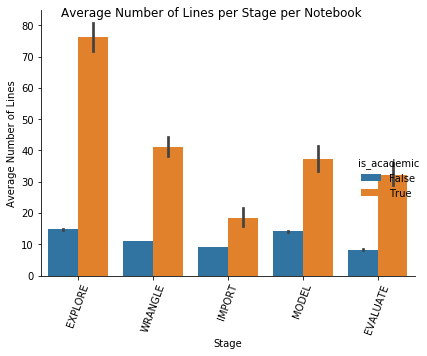

In [17]:
g = sns.catplot(data = (results_with_gorc.groupby(["is_academic","nb_id","readable_label"])
                        ["n_lines"].sum().reset_index())
                , hue = "is_academic", y = "n_lines", x = "readable_label",kind = "bar")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    ax.set_xlabel("Stage")
    ax.set_ylabel("Average Number of Lines")

plt.suptitle("Average Number of Lines per Stage per Notebook")
plt.tight_layout()

In [18]:
results_with_gorc[results_with_gorc["is_academic"]]["paper_id"].nunique()

2087

In [19]:
results_with_gorc[results_with_gorc["is_academic"]]["nb_id"].nunique()

7898

Text(0.5, 0.98, 'Average Number of Lines per Notebook')

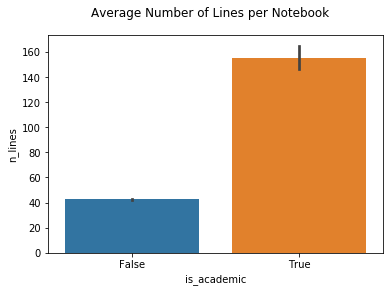

In [20]:
academic_nb_lengths = results_with_gorc.groupby(["nb_id","is_academic"])["n_lines"].sum().reset_index()
sns.barplot(x = academic_nb_lengths["is_academic"],
            y = academic_nb_lengths["n_lines"])

#     ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
#     ax.set_xlabel("Is Academic")
#     ax.set_ylabel("Total Number of Lines")

plt.suptitle("Average Number of Lines per Notebook")

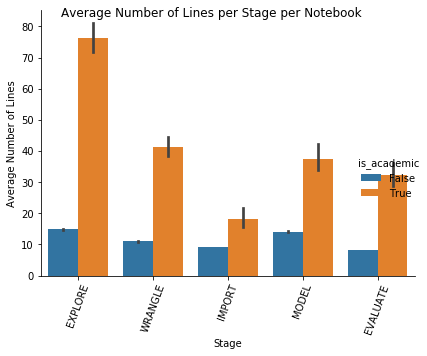

In [21]:
g = sns.catplot(data = (results_with_gorc.groupby(["is_academic","nb_id","readable_label"])
                        ["n_lines"].sum().reset_index())
                , hue = "is_academic", y = "n_lines", x = "readable_label",kind = "bar")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    ax.set_xlabel("Stage")
    ax.set_ylabel("Average Number of Lines")

plt.suptitle("Average Number of Lines per Stage per Notebook")
plt.tight_layout()

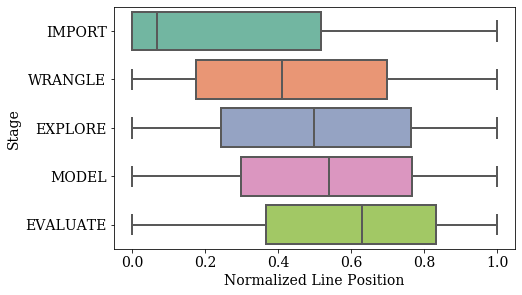

In [22]:
with plt.style.context("publications.mplstyle"): 
    nb_lengths = (results_with_gorc
                  .merge(results_with_gorc.groupby("nb_id")["n_lines"].sum().rename("total_nb_length"),
                         how = "left",
                         on = "nb_id"))
    nb_lengths["normalized_position"] = nb_lengths["code_line_no"] / nb_lengths["total_nb_length"]
    
    g = sns.boxplot(data = nb_lengths, x = "normalized_position", y = "readable_label",
                   palette="Set2", order = ORDERED_LABELS[:-1])
    
    plt.ylabel("Stage")
    plt.xlabel("Normalized Line Position")

    save_for_pub("figs/norm_doc_position.pdf")

In [23]:
nb_lengths.groupby("readable_label")["normalized_position"].median()

readable_label
EVALUATE    0.631579
EXPLORE     0.500000
IMPORT      0.070175
MODEL       0.540541
WRANGLE     0.410256
Name: normalized_position, dtype: float64

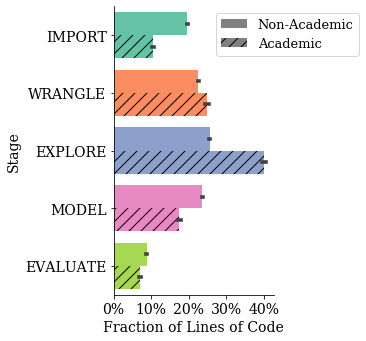

In [64]:
## import itertools
with plt.style.context("publications.mplstyle"): 
    unique_nb_id = nb_lengths["nb_id"].unique()
    unique_stages = READABLE_LABELS[1:]
    iterables = [unique_nb_id,unique_stages]
    all_possible_all_possible_stages_per_nb = list(itertools.product(unique_nb_id,unique_stages))
    line_count_per_nb_per_stage = nb_lengths\
                                    .groupby(["nb_id","readable_label","is_academic"])["n_lines"]\
                                    .sum().rename("n_lines_stage")\
                                    .reset_index(level = -1)\
                                    .reindex(pd.MultiIndex.from_product(iterables, names=['nb_id', 'readable_label']))\

    line_count_per_nb_per_stage = line_count_per_nb_per_stage.reset_index(-1)
    line_count_per_nb_per_stage["is_academic"] = line_count_per_nb_per_stage.groupby(level=0)["is_academic"].any() 
    line_count_per_nb_per_stage["n_lines_stage"] = line_count_per_nb_per_stage["n_lines_stage"].fillna(0)

    # line_count_per_nb_page["is_academic"] = line_count_per_nb_per_stage.
    total_line_counts = nb_lengths.drop_duplicates(["is_academic","nb_id"]).set_index("nb_id")["total_nb_length"]
    line_count_per_nb_per_stage = line_count_per_nb_per_stage.reset_index().merge(total_line_counts.reset_index())
    line_count_per_nb_per_stage["stage_fraction"] = line_count_per_nb_per_stage["n_lines_stage"] / \
                                                    line_count_per_nb_per_stage["total_nb_length"]

    g = sns.catplot(data = line_count_per_nb_per_stage, x = "stage_fraction", y = "readable_label",kind = "bar",hue = "is_academic",
                    order = ORDERED_LABELS[:-1], legend = False)

    
    num_stages = len(ORDERED_LABELS[:-1])
    hatch_list = [None, "//"]
    hatches = itertools.cycle(hatch_list)
    colors = itertools.cycle(sns.color_palette("Set2")[:num_stages])
    is_academic = ["Non-Academic","Academic"]
    
  
     
    for i, patch in enumerate(g.axes.flat[0].patches):
        # Blue bars first, then green bars
        if i % num_stages == 0:
            hatch = next(hatches)
        
        patch.set_facecolor(next(colors))
        
        patch.set_hatch(hatch)
        patch.set_label(is_academic[i%2])
      
    
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
  
    
    custom_patches = [patches.Patch(facecolor='grey', hatch=hatch_list[0]),
                      patches.Patch(facecolor='grey', hatch=hatch_list[1])]

    plt.legend(custom_patches, ['Non-Academic', 'Academic'], bbox_to_anchor=(0.6, 1))
    
    
#     plt.xticks(rotation=40)
    plt.ylabel("Stage")
    plt.xlabel("Fraction of Lines of Code")
    plt.title("")
    plt.tight_layout()
    save_for_pub("figs/frac_code_per_stage.pdf")

In [26]:
line_count_per_nb_per_stage.groupby(["is_academic","readable_label"])["stage_fraction"].mean()

is_academic  readable_label
False        EVALUATE          0.088220
             EXPLORE           0.255847
             IMPORT            0.195377
             MODEL             0.235617
             WRANGLE           0.224939
True         EVALUATE          0.070529
             EXPLORE           0.399975
             IMPORT            0.105555
             MODEL             0.175099
             WRANGLE           0.248841
Name: stage_fraction, dtype: float64

# Regression

In [27]:
n_domains = 5
gorc_domains_per_paper = gorc_domains.drop_duplicates(["pid","mag_fos"])[["mag_fos","pid","has_notebook","year_x","nb_id","title","n_inbound_citations"]]
top_n_domains = gorc_domains_per_paper.groupby("mag_fos").size().sort_values(ascending = False)[:n_domains].index

papers_in_top_n_domains = gorc_domains_per_paper[gorc_domains_per_paper["mag_fos"].isin(top_n_domains)].rename(columns = {"pid":"paper_id"})

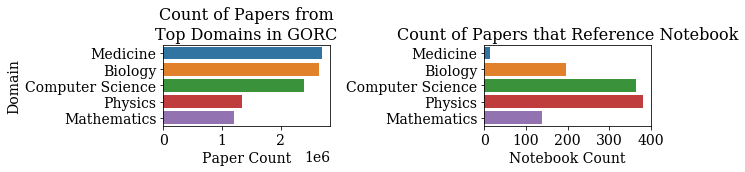

In [30]:
with plt.style.context("publications.mplstyle"): 
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 2, 1)
    domain_counts = papers_in_top_n_domains["mag_fos"].value_counts().sort_values(ascending = False).rename("Paper Counts")
    sns.barplot(y = domain_counts.index, x = domain_counts)
    plt.title("Count of Papers from\nTop Domains in GORC")
    plt.xlabel("Paper Count")
    plt.gca().ticklabel_format(axis = "x", style = "scientific")
    plt.ylabel("Domain")

    plt.subplot(222)
    notebook_counts = (papers_in_top_n_domains.groupby("mag_fos")
                            ["has_notebook"].sum().sort_values(ascending = False)).rename("Notebook Counts")
    sns.barplot(y = notebook_counts.index, x = notebook_counts, order = domain_counts.index)
    plt.title("Count of Papers that Reference Notebook")
    plt.xlabel("Notebook Count")
    plt.ylabel("")
    save_for_pub("figs/notebook_and_paper_counts.pdf")

    
    plt.tight_layout()

In [31]:
papers_in_top_n_domains

,mag_fos,paper_id,has_notebook,year_x,nb_id,title,n_inbound_citations
2,Biology,1009792,False,2012,NaN,NaN,2.0
3,Biology,10006097,False,2012,NaN,NaN,1.0
30,Biology,10070197,False,2012,NaN,NaN,15.0
46,Computer Science,10103267,False,2011,NaN,NaN,0.0
68,Mathematics,10138504,False,1999,NaN,NaN,2.0
...,...,...,...,...,...,...,...
81348167,Medicine,9660813,False,2000,NaN,NaN,0.0
81348230,Computer Science,9759736,False,2006,NaN,NaN,62.0
81348256,Medicine,9788833,False,2015,NaN,NaN,6.0
81348267,Computer Science,986442,False,1997,NaN,NaN,1.0


In [32]:
#Using all but the last category to prevent multicolinearity
one_hot_domains = pd.get_dummies(papers_in_top_n_domains["mag_fos"])
to_ols = pd.concat([papers_in_top_n_domains[["n_inbound_citations","has_notebook","year_x","nb_id","title","paper_id"]],one_hot_domains],
                  axis = 1).dropna(subset = ["n_inbound_citations","has_notebook","year_x"])
to_ols = to_ols[to_ols["year_x"].astype(int).between(2000,2020)]
to_ols["has_notebook"] = to_ols["has_notebook"].astype(int)
to_ols["year_x"] = 2020 - (to_ols["year_x"].astype(int))
# to_ols["n_inbound_citations"] = np.log(to_ols["n_inbound_citations"] + 1)

def get_ols_fit(y,X, add_intercept = True):
    if add_intercept:
        X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    return results


y_col = "n_inbound_citations"
X_cols = ["has_notebook","year_x"]+list(one_hot_domains.columns[:-1])
citations_results = get_ols_fit(to_ols[y_col],to_ols.loc[:,X_cols])

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                             OLS Regression Results                            
Dep. Variable:     n_inbound_citations   R-squared:                       0.026
Model:                             OLS   Adj. R-squared:                  0.026
Method:                  Least Squares   F-statistic:                 4.033e+04
Date:                 Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                         12:18:36   Log-Likelihood:            -4.5782e+07
No. Observations:              9167156   AIC:                         9.156e+07
Df Residuals:                  9167149   BIC:                         9.156e+07
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.5355   

In [33]:
papers_in_top_n_domains.groupby("mag_fos")["n_inbound_citations"].describe()

,count,mean,std,min,25%,50%,75%,max
mag_fos,,,,,,,,
Biology,2642998.0,14.981741,57.107017,0.0,1.0,5.0,14.0,27033.0
Computer Science,2394215.0,7.117187,49.440440,0.0,0.0,1.0,5.0,21489.0
Mathematics,1194901.0,7.871253,50.899994,0.0,0.0,1.0,6.0,17999.0
Medicine,2698805.0,8.768899,35.466433,0.0,0.0,2.0,8.0,21854.0
Physics,1334339.0,4.293183,20.115268,0.0,0.0,1.0,3.0,5076.0


Lots of interactions here? Having a notebook might matter more for different domains. Also some non-linearity

Negative Binomial allows for heteroskedasticity, allowing variance to be independent of the mean. Poisson is a special case of NB. Coefficents should be interpreted as percentage changes in the response variable. We note that the significance of this result does not change if we examine the top five or top 20 or top 5 domains. 

In [34]:
def get_GLM_fit(y,X,family,add_intercept = True,robust_cov=False):
    if add_intercept:
        X = sm.add_constant(X)
    
    model = sm.GLM(y, X,family = family)
    results = model.fit()
    print(results.summary())
    return results

In [35]:
get_GLM_fit(to_ols[y_col],to_ols.loc[:,X_cols],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:              9167156
Model:                             GLM   Df Residuals:                  9167149
Model Family:         NegativeBinomial   Df Model:                            6
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:            -2.7391e+07
Date:                 Thu, 13 Feb 2020   Deviance:                   2.0326e+07
Time:                         12:19:17   Pearson chi2:                 1.50e+08
No. Iterations:                     17                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2100   

In [36]:
to_ols[y_col].var()

1308.368560134819

In [37]:
to_ols[y_col].mean()

8.524289976084185

In [38]:
notebooks_in_top_n_domains = line_count_per_nb_per_stage

In [39]:
line_count_per_nb_per_stage

,nb_id,readable_label,is_academic,n_lines_stage,total_nb_length,stage_fraction
0,196368,WRANGLE,True,24.0,456,0.052632
1,196368,EXPLORE,True,372.0,456,0.815789
2,196368,MODEL,True,60.0,456,0.131579
3,196368,EVALUATE,True,0.0,456,0.000000
4,196368,IMPORT,True,0.0,456,0.000000
...,...,...,...,...,...,...
627085,71288,WRANGLE,False,8.0,40,0.200000
627086,71288,EXPLORE,False,11.0,40,0.275000
627087,71288,MODEL,False,15.0,40,0.375000
627088,71288,EVALUATE,False,6.0,40,0.150000


# Differences in Notebooks based on domain:
Maybe want to consider limiting this (or indeed the whole paper) to the top 5 domains? Results don't change appreciably

In [40]:
notebooks_in_papers = results_with_gorc.drop_duplicates(["nb_id","paper_id"])[["nb_id","paper_id"]].dropna()

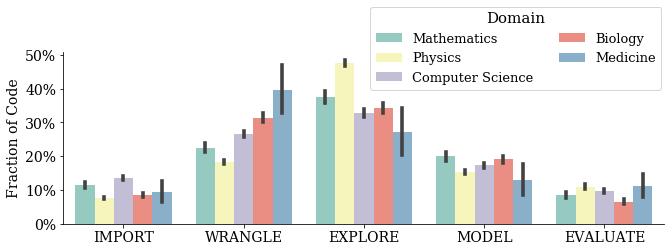

In [41]:
# line_counts_with_domain = line_count_per_nb_per_stage.reset_index().merge(papers_in_top_n_domains, on = "nb_id")
line_counts_with_domain = line_count_per_nb_per_stage.reset_index().merge(notebooks_in_papers,how = "right").merge(papers_in_top_n_domains[["paper_id","mag_fos"]],how = "left").dropna(subset = ["mag_fos"])

with plt.style.context("publications.mplstyle"):
    g = sns.catplot(data = line_counts_with_domain, y = "stage_fraction", hue = "mag_fos",kind = "bar",
                    x = "readable_label", order=ORDERED_LABELS[:-1], palette = "Set3",
                    legend = False)

    g.fig.set_size_inches(10,4)

    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.legend(title="Domain", loc = "upper left", ncol = 2,bbox_to_anchor=(0.5, 1.3))
#     plt.xticks(rotation=15)
    
    plt.ylabel("Fraction of Code")
    plt.xlabel(None)
#     plt.title("Fraction of Code per Stage per Domain")
    
    plt.tight_layout()
    
    plt.savefig("figs/per_domain_stage_fractions.pdf",bbox_inches="tight",transparent = True)


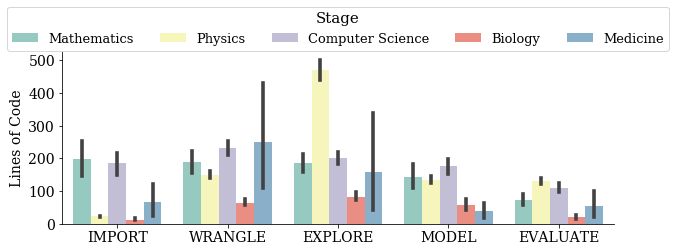

In [42]:
with plt.style.context("publications.mplstyle"):
    g = sns.catplot(data = line_counts_with_domain, y = "n_lines_stage", hue = "mag_fos",kind = "bar",
                    x = "readable_label",
                    legend = False,order=ORDERED_LABELS[:-1], palette = "Set3")

    g.fig.set_size_inches(10,4)

#     plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.legend(title="Stage", loc = "upper center", ncol = 5,bbox_to_anchor=(0.5, 1.3))
#     plt.xticks(rotation=15)
    
    plt.ylabel("Lines of Code")
    plt.xlabel(None)
#     plt.title("Fraction of Code per Stage per Domain")
    
    plt.tight_layout()
    
    plt.savefig("figs/per_domain_stage_counts.pdf",bbox_inches="tight",transparent = True)

# Notebook Entropy and Citations
Having a high entropy is significantly correlated with having more citations!

In [43]:
per_nb_entropy = line_counts_with_domain.groupby(["nb_id"])["stage_fraction"].apply(scipy.stats.entropy).rename("entropy").reset_index()
per_paper_entropy = notebooks_in_papers.merge(per_nb_entropy).groupby("paper_id")["entropy"].mean()
entropy_reg = per_paper_entropy.reset_index().merge(to_ols, how = "inner", on = "paper_id")
entropy_reg["entropy_z"] = scipy.stats.mstats.zscore(entropy_reg["entropy"])
del entropy_reg["nb_id"]

In [44]:
entropy_reg_y = "n_inbound_citations"
entropy_reg_X = ["year_x","entropy_z"] + list(one_hot_domains.columns[:-1]) 
get_GLM_fit(entropy_reg[entropy_reg_y],entropy_reg.loc[:,entropy_reg_X],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1085
Model Family:         NegativeBinomial   Df Model:                            6
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3314.6
Date:                 Thu, 13 Feb 2020   Deviance:                       2490.0
Time:                         12:19:39   Pearson chi2:                 8.42e+03
No. Iterations:                     14                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2708   

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Why does entropy matter?

In [45]:
line_counts_with_domain.head()
per_nb_stage_sizes = pd.pivot_table(line_count_per_nb_per_stage, index = ["nb_id"], 
                             columns = "readable_label", values = "n_lines_stage").reset_index()
per_paper_stage_sizes = notebooks_in_papers.merge(per_nb_stage_sizes).groupby("paper_id").sum()
del per_paper_stage_sizes["nb_id"]

In [46]:
per_paper_stage_sizes.head()

,EVALUATE,EXPLORE,IMPORT,MODEL,WRANGLE
paper_id,,,,,
17355.0,10.0,71.0,38.0,67.0,49.0
33504.0,4.0,35.0,24.0,14.0,33.0
58913.0,0.0,38.0,20.0,0.0,30.0
60945.0,108.0,132.0,35.0,135.0,130.0
91460.0,82.0,140.0,38.0,44.0,125.0


## Citations ~ Raw Stage Length 

In [47]:
to_size_reg = per_paper_stage_sizes.merge(to_ols, on = "paper_id")

to_size_reg_X = ["year_x","IMPORT","WRANGLE","EXPLORE","MODEL","EVALUATE"] + list(one_hot_domains.columns[:-1]) 
to_size_reg_y = "n_inbound_citations"



get_GLM_fit(to_size_reg[to_size_reg_y],to_size_reg[to_size_reg_X],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1081
Model Family:         NegativeBinomial   Df Model:                           10
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3294.3
Date:                 Thu, 13 Feb 2020   Deviance:                       2449.4
Time:                         12:19:47   Pearson chi2:                 8.09e+03
No. Iterations:                     15                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2462   

## Citations ~ Stage Fractions

In [48]:
per_paper_stage_fracs = per_paper_stage_sizes.div(per_paper_stage_sizes.sum(axis = 1), axis = 0).reset_index()

to_frac_reg = per_paper_stage_fracs.merge(to_ols, on = "paper_id")
to_frac_reg_X = ["year_x"] + ORDERED_LABELS[:-2]+ list(one_hot_domains.columns[:-1]) 
to_frac_reg_y = "n_inbound_citations"


get_GLM_fit(to_frac_reg[to_frac_reg_y],to_frac_reg[to_frac_reg_X],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1082
Model Family:         NegativeBinomial   Df Model:                            9
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3299.8
Date:                 Thu, 13 Feb 2020   Deviance:                       2460.4
Time:                         12:19:56   Pearson chi2:                 8.17e+03
No. Iterations:                     15                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5119   

## Citations ~ Entropy and Fractions

In [49]:
to_frac_and_ent_reg = per_paper_stage_fracs.merge(entropy_reg,on = "paper_id")
to_frac_and_ent_reg_res = get_GLM_fit(to_frac_and_ent_reg["n_inbound_citations"],
            to_frac_and_ent_reg[["year_x","entropy","WRANGLE","IMPORT","EXPLORE","MODEL"] + list(one_hot_domains.columns[:-1]) ],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1081
Model Family:         NegativeBinomial   Df Model:                           10
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3282.2
Date:                 Thu, 13 Feb 2020   Deviance:                       2425.2
Time:                         12:19:56   Pearson chi2:                 7.35e+03
No. Iterations:                     15                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2714   

## Citations ~ Entropy and Raw Lengths

In [50]:
to_size_and_ent_reg = per_paper_stage_sizes.merge(entropy_reg, on = "paper_id")
get_GLM_fit(to_size_and_ent_reg["n_inbound_citations"],
    to_size_and_ent_reg[["year_x","entropy","IMPORT","EXPLORE","MODEL","EVALUATE","WRANGLE"] + list(one_hot_domains.columns) ],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1080
Model Family:         NegativeBinomial   Df Model:                           11
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3272.5
Date:                 Thu, 13 Feb 2020   Deviance:                       2405.9
Time:                         12:19:56   Pearson chi2:                 7.09e+03
No. Iterations:                     15                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3759   

## Citations ~ Entropy and Z Score of Raw Lengths

In [51]:
per_paper_z_stage_sizes = per_paper_stage_sizes.apply(scipy.stats.mstats.zscore)
to_z_stage_size_and_ent_reg = per_paper_z_stage_sizes.merge(entropy_reg, on = "paper_id")
to_z_stage_size_and_ent_reg["entropy"] = scipy.stats.mstats.zscore(to_z_stage_size_and_ent_reg["entropy"])
get_GLM_fit(to_z_stage_size_and_ent_reg["n_inbound_citations"],
           to_z_stage_size_and_ent_reg[["year_x","entropy","IMPORT","EXPLORE","MODEL","EVALUATE","WRANGLE"] + list(one_hot_domains.columns) ],family = sm.families.NegativeBinomial())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1080
Model Family:         NegativeBinomial   Df Model:                           11
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3272.5
Date:                 Thu, 13 Feb 2020   Deviance:                       2405.9
Time:                         12:19:56   Pearson chi2:                 7.09e+03
No. Iterations:                     13                                         
Covariance Type:             nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0280   

# Domain Interactions
## Interactions of Notebook Stage Length and Domain

In [52]:
to_size_and_ent_reg = to_size_and_ent_reg.rename(columns = {"Computer Science":"Computer_Science"})
def get_interaction_formula(x1_cols,x2_cols):
    to_return = ""
    for x1 in x1_cols:
        for x2 in x2_cols:
            to_return = to_return + "{}*{} + ".format(x1,x2)
    return to_return[:-2]   

domain_interactions = get_interaction_formula(["Biology","Computer_Science","Mathematics","Medicine"], 
                                              ORDERED_LABELS[:-1])

domain_interactions_formula = "n_inbound_citations ~ " + domain_interactions 
print(sm.GLM.from_formula(domain_interactions_formula, data = to_size_and_ent_reg, 
                          family = sm.families.NegativeBinomial()).fit().summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1062
Model Family:         NegativeBinomial   Df Model:                           29
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3523.9
Date:                 Thu, 13 Feb 2020   Deviance:                       2908.6
Time:                         12:19:56   Pearson chi2:                 9.91e+03
No. Iterations:                     54                                         
Covariance Type:             nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [53]:
to_size_and_ent_reg[["Biology","Computer_Science","Physics","Medicine","Mathematics"]].sum(axis=1)

0       1
1       1
2       1
3       1
4       1
       ..
1087    1
1088    1
1089    1
1090    1
1091    1
Length: 1092, dtype: int64

## Interaction Effects With Z-Scores of Length:

In [54]:
to_z_stage_size_and_ent_reg = to_z_stage_size_and_ent_reg\
                            .rename(columns = {"Computer Science":"Computer_Science"})\
            
to_z_stage_size_and_ent_reg_res = sm.GLM.from_formula(domain_interactions_formula, data = to_z_stage_size_and_ent_reg,
                              family = sm.families.NegativeBinomial()).fit()
print(to_z_stage_size_and_ent_reg_res.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     n_inbound_citations   No. Observations:                 1092
Model:                             GLM   Df Residuals:                     1062
Model Family:         NegativeBinomial   Df Model:                           29
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -3523.9
Date:                 Thu, 13 Feb 2020   Deviance:                       2908.6
Time:                         12:19:57   Pearson chi2:                 9.91e+03
No. Iterations:                     54                                         
Covariance Type:             nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [55]:
to_z_stage_size_and_ent_reg_res.params

Intercept                     0.547599
Biology                       0.711882
IMPORT                       -4.695851
Biology:IMPORT               -1.538894
WRANGLE                       3.701754
Biology:WRANGLE              -1.534374
EXPLORE                      -1.841390
Biology:EXPLORE               0.124226
MODEL                        -0.010805
Biology:MODEL                -0.884713
EVALUATE                     -0.246217
Biology:EVALUATE              0.604653
Computer_Science              2.209720
Computer_Science:IMPORT       5.073574
Computer_Science:WRANGLE     -3.900065
Computer_Science:EXPLORE      0.913220
Computer_Science:MODEL       -0.104640
Computer_Science:EVALUATE     0.891699
Mathematics                   2.169372
Mathematics:IMPORT            5.297553
Mathematics:WRANGLE          -4.367201
Mathematics:EXPLORE           2.807474
Mathematics:MODEL            -1.493751
Mathematics:EVALUATE          0.916694
Medicine                     24.740106
Medicine:IMPORT          

In [56]:
def results_to_df(result):
    df = pd.read_html(result.summary().tables[1].as_html(),header=0,index_col=0)[0]
    df = df.rename(columns = {"[0.025":"CI_Low", "0.975]":"CI_High"})
    return df

results_df = results_to_df(to_z_stage_size_and_ent_reg_res)
results_df["domain"] = results_df.index.str.split(":").str[0]
results_df["stage"] = results_df.index.str.split(":").str[1]
results_df = results_df.dropna()
results_df = results_df.replace("Computer_Science","Computer Science")

#THere's nothing significant for Medicine, so we remove it:
results_df = results_df[results_df["domain"].isin(["Biology","Computer Science","Mathematics"])]
results_df["stage_order"] = results_df["stage"].map(lambda x: ORDERED_LABELS[:-1].index(x))

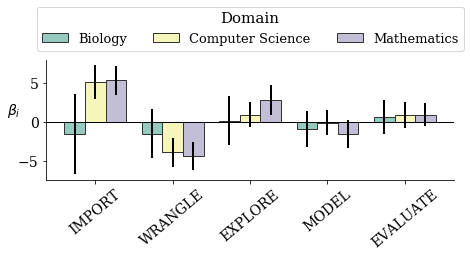

In [58]:
 with plt.style.context("publications.mplstyle"):
    g = sns.catplot(data = results_df, y = "coef", hue = "domain",kind = "bar",
                    x = "stage", order=ORDERED_LABELS[:-1], palette = "Set3",
                    legend = False,edgecolor=".2")

    g.fig.set_size_inches(7,5)
    
    plt.legend(title="Domain", ncol = 3 , loc = 'upper center',bbox_to_anchor=(0.5,1.5))

    two_std_errs = (results_df.sort_values(["stage_order","domain"])["std err"] * 2).tolist()
    plt.axhline(0, color='black', lw=1)
    
    for i,patch in enumerate(g.axes.flatten()[0].patches):
        # get_width pulls left or right; get_y pushes up or down
        
        err_bar_x = patch.get_x() + (patch.get_width()/2)
        err_bar_y = patch.get_y() + (patch.get_height())

        plt.errorbar(yerr = two_std_errs[i], x = err_bar_x, y =  err_bar_y, c= "black")

    
    plt.ylabel(r"$ \beta_i $", rotation = 0)
    plt.xlabel("")
    plt.xticks(None, rotation = 40)
    
#     plt.title("Fraction of Code per Stage per Domain")
    
    plt.tight_layout()
    plt.savefig("figs/per_domain_betas.pdf",bbox_inches="tight",transparent = True)
    